<a href="https://colab.research.google.com/github/vimalkumarasamy/computer_vision/blob/master/Panorama%20with%20RANSAC%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [71]:
cd '/content/gdrive/My Drive/Computer_Vision/panorama'

/content/gdrive/My Drive/Computer_Vision/panorama


In [0]:
import os
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import random
# ! pip uninstall opencv python
# ! pip install opencv-python==3.4.2.17
# ! pip install opencv-contrib-python==3.4.2.17

In [0]:
def ssd(arr1,arr2):
  import numpy as np
  return np.sum(np.square(arr1-arr2)) 

def pad(img,n):
  dim=img.shape
  if len(dim)==2:
    img_out=np.ones([dim[0]+n,dim[1]+n])
    img_out[n//2:n//2+dim[0],n//2:n//2+dim[1]]=img
  if len(dim)==3:
    img_out=np.ones([dim[0]+n,dim[1]+n,dim[2]])
    img_out[n//2:n//2+dim[0],n//2:n//2+dim[1],:]=img
  img_out = cv2.normalize(img_out, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  return(img_out)
  

def match_keypoints(des_1,des_2,kp_1,kp_2):
  ratios=[]
  matches=[]
  for i in range(len(des_2)):
    arr=[]
    for j in range(len(des_1)):
      arr=arr+[ssd(des_2[i],des_1[j])]
    arr=np.array(arr)
    ind=arr.argsort()[0:2]
    ind1,ind2=ind[0],ind[1]
    val1,val2=arr[ind1],arr[ind2]
    ratio=val1/val2
    ratios=ratios+[ratio]
    matches=matches+[ind1]
  # print(min(ratios))
  # top5=np.array(ratios).argsort()[0:10]
  top=np.where(np.array(ratios) < 0.2)[0]
  best_match=[]
  for i in top:
    best_match=best_match+[[i,matches[i]]]
  points=[]
  for i in best_match:
    left,right=kp_1[i[1]].pt,kp_2[i[0]].pt
    points=points+[[left[0],left[1],right[0],right[1]]]

  return(points)

def find_homography(img_1,img_2):
  sift = cv2.xfeatures2d.SIFT_create()
  kp_1,des_1 = sift.detectAndCompute(img_1,None)
  kp_2,des_2 = sift.detectAndCompute(img_2,None)
  l1,b1=img_1.shape
  l2,b2=img_2.shape
  coords=match_keypoints(des_1,des_2,kp_1,kp_2)
  status,H=ransac(coords)
  return(status,H)



def ransac(points):
  s=2000
  homograph_final=np.array([[0,0,0],[0,0,0],[0,0,0]])
  inliner_max=0
  status=False
  for i in range(s):
    items = random.sample(points,4)
    l,r=[],[]
    for j in items:
      l=l+[[j[0],j[1]]]
      r=r+[[j[2],j[3]]]
    H=homograph(l,r)
    inliner=0
    for k in points:
      right=np.array([[k[2]],[k[3]],[1]])
      right_trans=np.matmul(np.array(H),right)
      right_trans=np.array([right_trans[0][0]/right_trans[2][0],right_trans[1][0]/right_trans[2][0]])
      left =np.array([k[0],k[1]])
      if ssd(left,right_trans)< np.sqrt(8):
        inliner=inliner+1
    if inliner>inliner_max:
      inliner_max=inliner
      homograph_final=H
      status=True
  # print('Among ',len(points),' points, the number of inliners were ',inliner_max)
  return(status,homograph_final)



def stitch_images(img1,img2):
  dim1,dim2,dim=img1.shape,img2.shape,[]
  dim=[max(dim1[0],dim2[0]),max(dim1[0],dim2[0]),3]
  
  if dim2[0]>dim1[0]:
    img1=np.vstack((img1,np.zeros([dim2[0]-dim1[0],dim1[1],3])))
  elif dim2[0]<dim1[0]:
    img2=np.vstack((img2,np.zeros([dim1[0]-dim2[0],dim2[1],3])))
  dim1,dim2=img1.shape,img2.shape
  if dim2[1]>dim1[1]:
    img1=np.hstack((img1,np.zeros([dim1[0],dim2[1]-dim1[1],3])))
  elif dim2[1]<dim1[1]:
    img2=np.hstack((img2,np.zeros([dim2[0],dim1[1]-dim2[1],3])))

  out=np.maximum(img1, img2)
  out = cv2.normalize(out, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  return(out)


def overlap(img1,img2):
  dim1,dim2=img1.shape,img2.shape  
  if dim2[0]>dim1[0]:
    img1=np.vstack((img1,np.zeros([dim2[0]-dim1[0],dim1[1],3])))
  elif dim2[0]<dim1[0]:
    img2=np.vstack((img2,np.zeros([dim1[0]-dim2[0],dim2[1],3])))
  dim1,dim2=img1.shape,img2.shape
  if dim2[1]>dim1[1]:
    img1=np.hstack((img1,np.zeros([dim1[0],dim2[1]-dim1[1],3])))
  elif dim2[1]<dim1[1]:
    img2=np.hstack((img2,np.zeros([dim2[0],dim1[1]-dim2[1],3])))
  prod=np.multiply(img1, img2)
  summ=prod[:,:,0]+prod[:,:,1]+prod[:,:,2]
  percent=float(np.count_nonzero(summ)/(summ.shape[0] * summ.shape[1]))
  return(percent)


def combine(left_image,right_image):
  # left_image=os.getcwd()+'/photos/nevada4.jpg'
  # right_image=os.getcwd()+'/photos/nevada5.jpg'
  p=1000
  img_1 = cv2.imread(left_image,0)
  img_2 = cv2.imread(right_image,0)
  img_1 = pad(img_1,p)
  img_2 = pad(img_2,p)
  l2,b2=img_2.shape
  status,H=find_homography(img_1,img_2)
  if status:
    img_2 = cv2.imread(right_image)[:,:,::-1]
    img_1 = cv2.imread(left_image)[:,:,::-1]
    img_1 = pad(img_1,p)
    img_2 = pad(img_2,p)
    out = cv2.warpPerspective(img_2, H, (b2+2000,l2))
    if overlap(img_1,out)>0.1:
      stitch=stitch_images(out,img_1)
    else:
      stitch = cv2.imread(left_image)[:,:,::-1]
  else:
    stitch = cv2.imread(left_image)[:,:,::-1]
  return(stitch) 


def homograph(L,R):
  x1_=R[0][0]
  y1_=R[0][1]
  x2_=R[1][0]
  y2_=R[1][1]
  x3_=R[2][0]
  y3_=R[2][1]
  x4_=R[3][0]
  y4_=R[3][1]
  x1 =L[0][0]
  y1 =L[0][1]
  x2 =L[1][0]
  y2 =L[1][1]
  x3 =L[2][0]
  y3 =L[2][1]
  x4 =L[3][0]
  y4 =L[3][1]

  PH=np.array([[-x1,-y1,-1,0,0,0,(x1*x1_),(y1*x1_),(x1_)], [0,0,0,-x1,-y1,-1,(x1*y1_),(y1*y1_),y1_],[-x2,-y2,-1,0,0,0,(x2*x2_),(y2*x2_),x2_],[0,0,0,-x2,-y2,-1,(x2*y2_),(y2*y2_),y2_],
              [-x3,-y3,-1,0,0,0,(x3*x3_),(y3*x3_),x3_],[0,0,0,-x3,-y3,-1,(x3*y3_),(y3*y3_),y3_],[-x4,-y4,-1,0,0,0,(x4*x4_),(y4*x4_),x4_],[0,0,0,-x4,-y4,-1,(x4*y4_),(y4*y4_),y4_],[0,0,0,0,0,0,0,0,1]])
  Y=np.array([[0,0,0,0,0,0,0,0,1]])
  PH_inv = np.linalg.pinv(PH)
  H=np.matmul(np.linalg.pinv(PH),np.transpose(Y))
  Homograph=np.array([[H[0][0],H[1][0],H[2][0]],[H[3][0],H[4][0],H[5][0]],[H[6][0],H[7][0],H[8][0]]])
  H_=np.linalg.inv(Homograph)
  return(H_)

In [0]:
# another test case
left_image=os.getcwd()+'/photos/test1.jpg'
right_image=os.getcwd()+'/photos/test2.jpg'
p=1000
img_1 = cv2.imread(left_image,0)
img_2 = cv2.imread(right_image,0)
img_1 = pad(img_1,p)
img_2 = pad(img_2,p)
l2,b2=img_2.shape

sift = cv2.xfeatures2d.SIFT_create()
kp_1,des_1 = sift.detectAndCompute(img_1,None)
kp_2,des_2 = sift.detectAndCompute(img_2,None)
l1,b1=img_1.shape
l2,b2=img_2.shape

ratios=[]
matches=[]
for i in range(len(des_2)):
  arr=[]
  for j in range(len(des_1)):
    arr=arr+[ssd(des_2[i],des_1[j])]
  arr=np.array(arr)
  ind=arr.argsort()[0:2]
  ind1,ind2=ind[0],ind[1]
  val1,val2=arr[ind1],arr[ind2]
  ratio=val1/val2
  ratios=ratios+[ratio]
  matches=matches+[ind1]


In [0]:
# np.sum(np.where( np.array(ratios) < 0.2 ))
x=np.where( np.array(ratios) < 0.2 )
len(x[0])

333

In [0]:
len(des_1) * len(des_2)

69230280

In [0]:
img_0 = cv2.imread(os.getcwd()+'/photos/nevada3.jpg',0)
img_1 = cv2.imread(os.getcwd()+'/photos/nevada4.jpg',0)
img_2 = cv2.imread(os.getcwd()+'/photos/nevada5.jpg',0)
img_3 = cv2.imread(os.getcwd()+'/photos/nikku.jpg',0)
p=1000
img_0 = pad(img_0,p)
img_1 = pad(img_1,p)
img_2 = pad(img_2,p)
img_3 = pad(img_3,p)
l1,b1=img_1.shape
l2,b2=img_2.shape
l3,b3=img_3.shape
status,H=find_homography(img_1,img_2)

0.0091412775


In [0]:
H

array([[ 5.71548160e-01,  3.63865694e-02,  1.25673450e+03],
       [-1.25760885e-01,  7.61570754e-01,  2.00124845e+02],
       [-6.19502769e-05,  2.69550276e-06,  8.67894432e-01]])

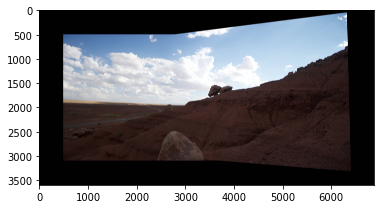

In [0]:
left_image=os.getcwd()+'/photos/nevada4.jpg'
right_image=os.getcwd()+'/photos/nevada5.jpg'
p=1000
img_1 = cv2.imread(left_image,0)
img_2 = cv2.imread(right_image,0)
img_1 = pad(img_1,p)
img_2 = pad(img_2,p)
l2,b2=img_2.shape
status,H=find_homography(img_1,img_2)
if status:
  img_2 = cv2.imread(right_image)[:,:,::-1]
  img_1 = cv2.imread(left_image)[:,:,::-1]
  img_1 = pad(img_1,p)
  img_2 = pad(img_2,p)
  out = cv2.warpPerspective(img_2, H, (b2+2000,l2))
  if overlap(img_1,out)>0.2:
    stitch=stitch_images(out,img_1)
  else:
    stitch = cv2.imread(left_image)[:,:,::-1]
else:
  stitch = cv2.imread(left_image)[:,:,::-1]
plt.imshow(stitch)
plt.show()

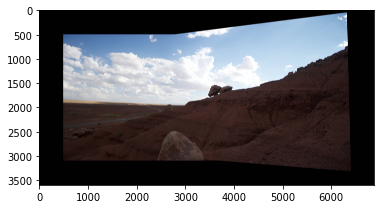

In [0]:
left_image=os.getcwd()+'/photos/nevada4.jpg'
right_image=os.getcwd()+'/photos/nevada5.jpg'
stitch2=combine(left_image,right_image)
plt.imshow(stitch2)
plt.show()

Left image


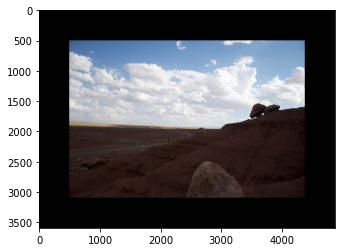

Right image Raw


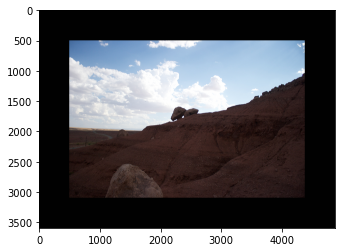

Right image Warped


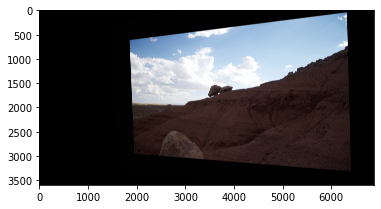

Stitched Image


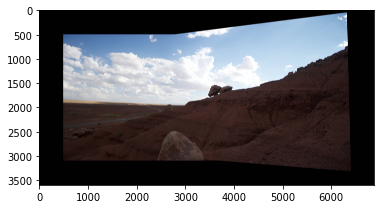

In [0]:
print("Left image")
img_1 = cv2.imread(os.getcwd()+'/photos/nevada4.jpg')[:,:,::-1]
img_2 = cv2.imread(os.getcwd()+'/photos/nevada5.jpg')[:,:,::-1]
img_1 = pad(img_1,p)
img_2 = pad(img_2,p)
plt.imshow(img_1)
plt.show()
print("Right image Raw")
plt.imshow(img_2)
plt.show()
print("Right image Warped")
out = cv2.warpPerspective(img_2, H, (b2+2000,l2))
plt.imshow(out)
plt.show()
stitch=stitch_images(out,img_1)
print("Stitched Image")
plt.imshow(stitch)
plt.show()


In [0]:
cv2.imwrite('stitched.jpg', cv2.cvtColor(stitch, cv2.COLOR_RGB2BGR))

True

In [0]:
# The test case that takes two images and combines things
left_image=os.getcwd()+'/photos/test1.jpg'
right_image=os.getcwd()+'/photos/test2.jpg'
stitch=combine(left_image,right_image)
plt.imshow(stitch)
plt.show()
cv2.imwrite('stitched.jpg', cv2.cvtColor(stitch, cv2.COLOR_RGB2BGR))


In [0]:
def match_keypoints(des_1,des_2,kp_1,kp_2):
  ratios=[]
  matches=[]
  for i in range(len(des_2)):
    arr=[]
    for j in range(len(des_1)):
      arr=arr+[ssd(des_2[i],des_1[j])]
    arr=np.array(arr)
    ind=arr.argsort()[0:2]
    ind1,ind2=ind[0],ind[1]
    val1,val2=arr[ind1],arr[ind2]
    ratio=val1/val2
    ratios=ratios+[ratio]
    matches=matches+[ind1]
  # print(min(ratios))
  # top5=np.array(ratios).argsort()[0:10]
  top=np.where(np.array(ratios) < 0.2)[0]
  best_match=[]
  for i in top:
    best_match=best_match+[[i,matches[i]]]
  points=[]
  for i in best_match:
    left,right=kp_1[i[1]].pt,kp_2[i[0]].pt
    points=points+[[left[0],left[1],right[0],right[1]]]

  return(points)

In [0]:
def ransac(points):
  s=2000
  homograph_final=np.array([[0,0,0],[0,0,0],[0,0,0]])
  inliner_max=0
  status=False
  for i in range(s):
    items = random.sample(points,4)
    l,r=[],[]
    for j in items:
      l=l+[[j[0],j[1]]]
      r=r+[[j[2],j[3]]]
    H=homograph(l,r)
    inliner=0
    for k in points:
      right=np.array([[k[2]],[k[3]],[1]])
      right_trans=np.matmul(np.array(H),right)
      right_trans=np.array([right_trans[0][0]/right_trans[2][0],right_trans[1][0]/right_trans[2][0]])
      left =np.array([k[0],k[1]])
      if ssd(left,right_trans)< np.sqrt(8):
        inliner=inliner+1
    if inliner>inliner_max:
      inliner_max=inliner
      homograph_final=H
      status=True
  # print('Among ',len(points),' points, the number of inliners were ',inliner_max)
  return(status,homograph_final)

# H=ransac(coords)

Among  168  points, the number of inliners were  65


In [0]:
def homograph(L,R):
  x1_=R[0][0]
  y1_=R[0][1]
  x2_=R[1][0]
  y2_=R[1][1]
  x3_=R[2][0]
  y3_=R[2][1]
  x4_=R[3][0]
  y4_=R[3][1]
  x1 =L[0][0]
  y1 =L[0][1]
  x2 =L[1][0]
  y2 =L[1][1]
  x3 =L[2][0]
  y3 =L[2][1]
  x4 =L[3][0]
  y4 =L[3][1]

  PH=np.array([[-x1,-y1,-1,0,0,0,(x1*x1_),(y1*x1_),(x1_)], [0,0,0,-x1,-y1,-1,(x1*y1_),(y1*y1_),y1_],[-x2,-y2,-1,0,0,0,(x2*x2_),(y2*x2_),x2_],[0,0,0,-x2,-y2,-1,(x2*y2_),(y2*y2_),y2_],
              [-x3,-y3,-1,0,0,0,(x3*x3_),(y3*x3_),x3_],[0,0,0,-x3,-y3,-1,(x3*y3_),(y3*y3_),y3_],[-x4,-y4,-1,0,0,0,(x4*x4_),(y4*x4_),x4_],[0,0,0,-x4,-y4,-1,(x4*y4_),(y4*y4_),y4_],[0,0,0,0,0,0,0,0,1]])
  Y=np.array([[0,0,0,0,0,0,0,0,1]])
  PH_inv = np.linalg.pinv(PH)
  H=np.matmul(np.linalg.pinv(PH),np.transpose(Y))
  Homograph=np.array([[H[0][0],H[1][0],H[2][0]],[H[3][0],H[4][0],H[5][0]],[H[6][0],H[7][0],H[8][0]]])
  H_=np.linalg.inv(Homograph)
  return(H_)

In [0]:
H

array([[ 6.55623772e-01,  4.25245403e-02,  1.20407891e+03],
       [-9.88009958e-02,  8.16082946e-01,  1.01015395e+02],
       [-6.10587136e-05,  2.69611929e-06,  8.90149286e-01]])